__Análise de dados Docking - 2 Um tratamento estatístico__

Diferente da parte 1, aqui vamos ser mais dinâmicos. Iremos utilizar formas mais diretas de realizar as operações com os dados. Além de trazer um tratamento mais estatístico para os dados, buscando porcentagem de ocupação de energia, média, mediana e desvio-pad, além de outros tramentos.

Caso não tenha alguma biblioteca

In [1]:
'''
!pip install rmsd
!pip install periodictable
!pip install heatmapz
!pip install plotly
'''

'\n!pip install rmsd\n!pip install periodictable\n!pip install heatmapz\n!pip install plotly\n'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rmsd
import periodictable as pt
from pylab import rcParams
from heatmap import heatmap, corrplot
rcParams['figure.figsize'] = 7,7 
sns.set(color_codes=True, font_scale=1.2)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
#Abrir gráficos plotly em uma nova guia
#pio.renderers.default = 'browser'
fig=go.Figure()

%matplotlib inline  

Esse algoritmo analisa uma pasta com arquivos pdbqt gerados por docking com o vina e as transforma em um dataframe com a posição do centro de mass, valor do RMSD e energia.

Para esse notebook funcionar corretamente, você precisa instalar bibliotecas como, rmsd, periodictable, numpy e pandas.

Qualquer questão escreva para rafael.pleite@usp.br

Funções para extrair os dados dos arquivos .pdbqt

In [3]:
def load(i):
    data = ''
    with open(i) as fp:
        data = fp.read()
    data = data.split('\n')
    return data

def CalcMassAtom(Matrix):
    data = []
    for x in range(len(Matrix)):
        A = Matrix[x].split()
        if len(A) != 0 and A[0] == 'HETATM' and A[2][0] != 'H':
            data.append([A[5], A[6], A[7], A[2][0]])
    return data

def AssingMass(Pos_atom):
    for i in range(len(Pos_atom)): #Change the atom name for atom mass
        for j in range(len(Pos_atom[0])):
            Pos_atom[i][j][3] = MassAtom(Pos_atom[i][j][3])
    return Pos_atom

def PositionAtom(Data_, n_atom):
    Positions = []
    for i in range(0, len(Data_), n_atom):
        Positions.append(Data_[i:n_atom+i])
    return Positions

def MassAtom(At):
    Atom = str(At)
    if Atom == 'C':
        return float(pt.C.mass)
    elif Atom == 'O':
        return float(pt.O.mass)
    elif Atom == 'N':
        return float(pt.N.mass)
    elif Atom == 'F':
        return float(pt.F.mass)
    elif Atom == 'Cl':
        return float(pt.Cl.mass)
    else:
        return None
    
def CM(Pos_mass):
    Matrix = np.array(Pos_mass)
    PositionCM = [float(0), float(0), float(0)]
    M = 0
    for i in range(len(Matrix)):
        M += float(Matrix[i,3])
        PositionCM[0] += float(Matrix[i,0])*float(Matrix[i,3])
        PositionCM[1] += float(Matrix[i,1])*float(Matrix[i,3])
        PositionCM[2] += float(Matrix[i,2])*float(Matrix[i,3])
    return [PositionCM[0]/M, PositionCM[1]/M, PositionCM[2]/M]

def TransformFloat(M):
    P = M
    for i in range(len(P)):
        for j in range(len(P[i])):
            P[i][j] = float(P[i][j])
    return P

Essa parte é vital para o funcionamente correto do código.

Abaixo entre com o caminho da pasta com os arquivos .pdbqt e o correto número de átomos do ligante menos o número de hidrogênios.

Exemplo: Luteolin possui a seguinte fórmula C15H10O6, ou seja, são (31 átomos - 10 átomos de hidrogênios) = 21 átomos

In [4]:
path = r'C:\SARSCOV2\OAII\LuteolinPLProPOOL\LuteolinPLpro\Teste\Resultados'
n_atom = 21

Entre aqui com o nome do arquivo de referencial, isto é, o seu melhor resultado para ser o referencial do sistema que calcula o RMSD

In [5]:
Referential_pos = r'\proteina-ligante,60,23,15,.pdbqt'

In [6]:
Referential = list(np.array(AssingMass(PositionAtom(CalcMassAtom(load(path + Referential_pos)), n_atom)), float)[0,:,:3])
    
Principal = np.zeros((1,5))
    
if str(input('Digite [S] para analisar todos os arquivos .pdbqt do diretório ou [N] para analisar apenas o seu referencial de RMSD: ')).upper() == 'S':
    for root, directories, files in os.walk(path, topdown=False):
        if root == path:
            for name in files:
                if name.find('pdbqt') != -1:
                    Data_load = load(str(path + r'\b'[0]+ name))
                    Data_ = CalcMassAtom(Data_load)

                    #Take de coordinates of atom and your name
                    Pos_atom = PositionAtom(Data_, n_atom)
                    Pos_atom = AssingMass(Pos_atom)

                    CM_pos = [] #Calculate de center of mass
                    for x in Pos_atom:
                        CM_pos.append(CM(x))

                    Array_pos_atom = np.array(Pos_atom, float)
                    RMSD = []
                    for j in range(len(CM_pos)):
                        RMSD.append(rmsd.rmsd(Referential, list(Array_pos_atom[j,:,:3])))

                    Energy = []
                    for x in range(len(Data_load)):
                        A = Data_load[x].split()
                        if len(A) >= 3 and A[1] == 'VINA':
                            Energy.append(float(A[3]))

                    No_principal = []
                    for i in range(len(RMSD)):
                        No_principal.append([CM_pos[i][0], CM_pos[i][1], CM_pos[i][2] ,RMSD[i], Energy[i]])
                    No_principal = np.array(No_principal)
                    Principal = np.append(Principal, No_principal, axis=0) #add RMSD to principal
                    
else:
    for root, directories, files in os.walk(path, topdown=False):
        for name in files:
            if name.find(Referential_pos[1:]) != -1:
                Data_load = load(str(path + r'\b'[0]+ name))
                Data_ = CalcMassAtom(Data_load)
                
                #Take de coordinates of atom and your name
                Pos_atom = PositionAtom(Data_, n_atom)
                Pos_atom = AssingMass(Pos_atom)
                
                CM_pos = [] #Calculate de center of mass
                for x in Pos_atom:
                    CM_pos.append(CM(x))
                        
                Array_pos_atom = np.array(Pos_atom, float)
                RMSD = []
                for j in range(len(CM_pos)):
                    RMSD.append(rmsd.rmsd(Referential, list(Array_pos_atom[j,:,:3])))
                    
                Energy = []
                for x in range(len(Data_load)):
                    A = Data_load[x].split()
                    if len(A) >= 3 and A[1] == 'VINA':
                        Energy.append(float(A[3]))
                            
                No_principal = []
                for i in range(len(RMSD)):
                    No_principal.append([CM_pos[i][0], CM_pos[i][1], CM_pos[i][2] ,RMSD[i], Energy[i]])
                No_principal = np.array(No_principal)
                Principal = np.append(Principal, No_principal, axis=0) #add RMSD to principal
                
Principal = np.delete(Principal, 0, 0)
df = pd.DataFrame(Principal, columns=('x', 'y', 'z', 'RMSD', 'Energy'))
df = df[df['Energy'] <=0]

Digite [S] para analisar todos os arquivos .pdbqt do diretório ou [N] para analisar apenas o seu referencial de RMSD: S


Informações sobre o DataFrame.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3363 entries, 0 to 3362
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       3363 non-null   float64
 1   y       3363 non-null   float64
 2   z       3363 non-null   float64
 3   RMSD    3363 non-null   float64
 4   Energy  3363 non-null   float64
dtypes: float64(5)
memory usage: 157.6 KB


In [8]:
df.describe()

,x,y,z,RMSD,Energy
count,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000
mean,59.431411,33.216120,19.657752,34.093501,-4.347904
std,23.599018,18.789127,16.047603,11.292593,2.382548
min,14.137584,-5.355720,-12.828169,0.000000,-8.900000
25%,38.770648,17.177991,5.352823,25.872291,-5.900000
50%,60.188575,33.967457,19.632746,33.996668,-5.000000
75%,75.821287,48.508908,33.598267,40.883737,-3.000000
max,108.151367,71.592981,51.405386,69.362703,-0.000000


__Gráficos__

Gráfico de correlação

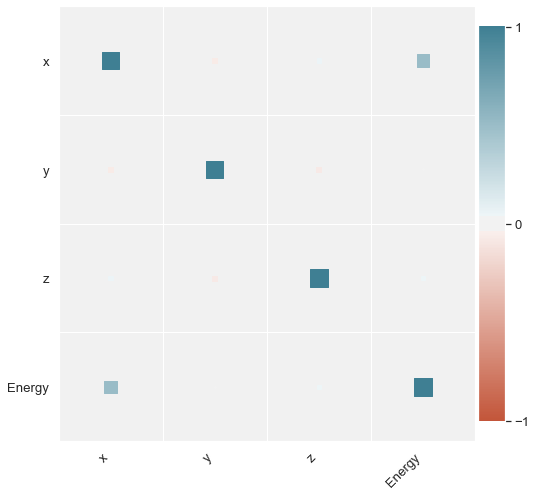

In [9]:
plt.figure(figsize=(8, 8))
corrplot(df.drop('RMSD', axis=1).corr(), size_scale=300)
#plt.savefig('Correlacao'+'.png', dpi=600)

Aqui, vamos trabalhar com clusters para energias <=-7.5, <=-8.0, <=-8.5.

Gráfico da distribuição espacial dos pontos nos intervalos. Fique avontade para modificar o termo (abs(i) * 3), pois ele modifica o tamanho dos pontos do gráfico.

In [13]:
#Caso deseje visualizar a distribuição, rode.

for i in [-7.5, -8.0, -8.5]:
    siz = df[df['Energy'] <= i].apply(abs).apply(lambda x: x**(abs(i) * 3) )['Energy']
    fig = px.scatter_3d(df[df['Energy'] <=i], x = 'x',  y = 'y',  z = 'z', color = 'Energy', size= siz)
    fig.show()


__CLUSTERIZAÇÃO__

Daqui para frente iremos trabalhar com a clusterização dos dados coletados. Fique a vontade para modificar os parâmetros dos algoritmos de clusterização da forma que achar melhor.


__Vamos tentar usar o DBSCAN__

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler



Para energia de -6.5 kcal/mol
              mean  median       std  Ocupação %
Cluster                                        
-1      -6.500000   -6.50  0.000000    0.512362
 0      -6.793103   -6.80  0.198082    5.176174
 1      -7.621429   -7.65  0.457744    8.410626
 2      -7.395302   -7.40  0.578263   57.904832
 3      -6.850000   -6.85  0.057735    0.719935
 4      -7.642857   -7.70  0.696311   15.462834
 5      -6.933333   -6.90  0.367630    2.186080
 6      -6.830000   -6.80  0.283039    1.794582
 7      -6.775000   -6.80  0.191839    7.832576


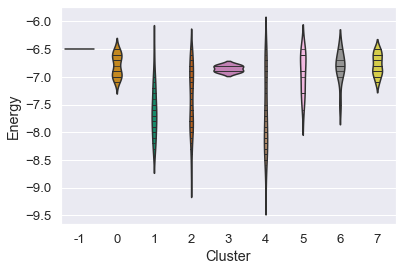

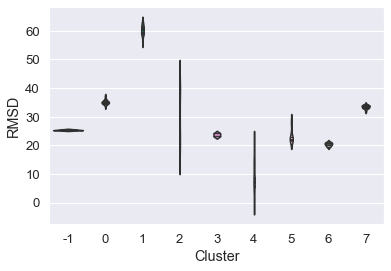

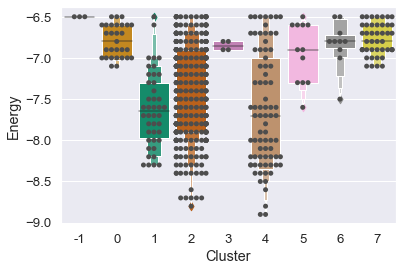

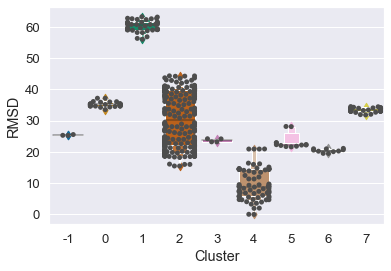



Para energia de -7.5 kcal/mol
              mean  median       std  Ocupação %
Cluster                                        
-1      -7.550000   -7.55  0.070711    0.866173
 0      -7.868966   -7.80  0.268732   13.090116
 1      -7.926506   -7.90  0.310029   37.738771
 2      -7.993750   -7.85  0.407380    7.336660
 3      -7.927500   -7.90  0.225306   18.189640
 4      -8.104082   -8.20  0.352940   22.778638


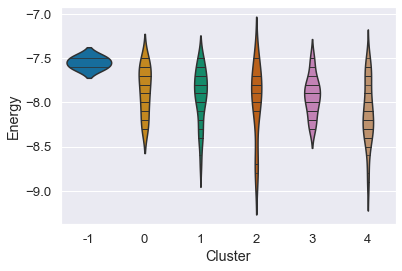

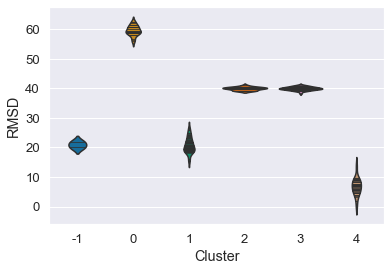

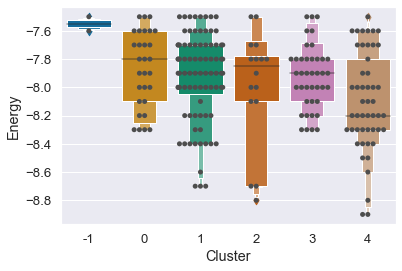

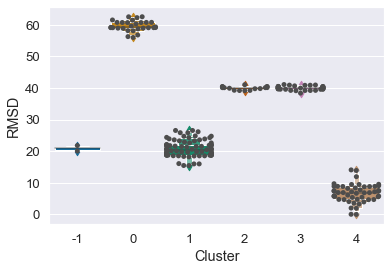



Para energia de -8.0 kcal/mol
              mean  median       std  Ocupação %
Cluster                                        
0       -8.163636    -8.2  0.128629   10.587126
1       -8.108333    -8.0  0.156428   11.471351
2       -8.342857    -8.1  0.369040    6.885169
3       -8.127778    -8.1  0.122741   17.248290
4       -8.291176    -8.3  0.240413   33.235086
5       -8.309524    -8.3  0.236442   20.572978


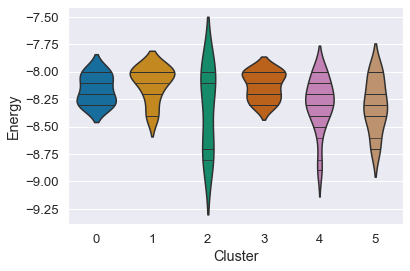

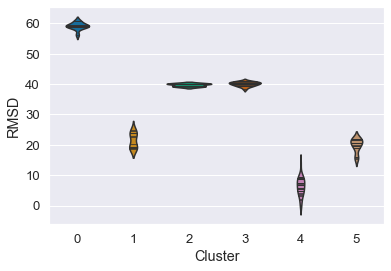

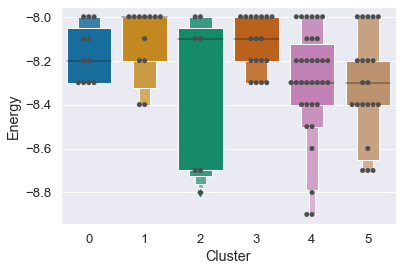

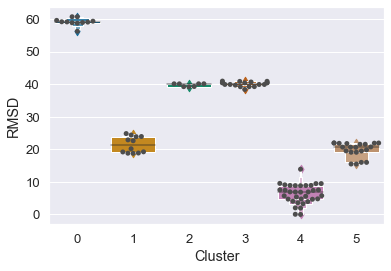



Para energia de -8.5 kcal/mol
              mean  median       std  Ocupação %
Cluster                                        
-1      -8.733333    -8.7  0.057735   23.165340
 0      -8.700000    -8.7  0.189737   46.153846
 1      -8.675000    -8.7  0.050000   30.680813


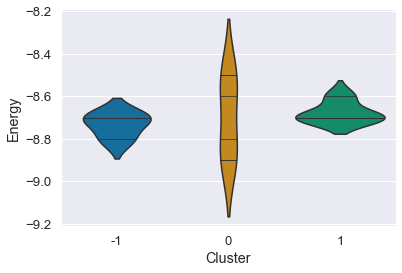

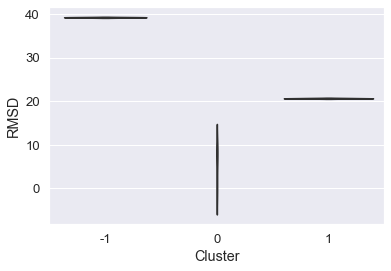

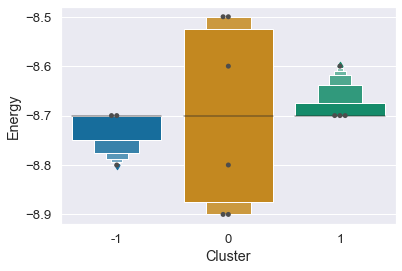

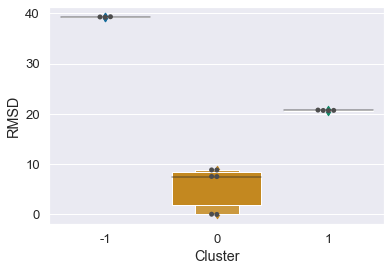

In [19]:
valores_busca = [-6.5, -7.5, -8.0, -8.5]
for i in valores_busca:
    #CLUSTERIZACAO
    clustering = DBSCAN(eps= 12, min_samples = 4).fit(df[df['Energy'] <= i].drop(['RMSD', 'Energy'], axis=1))
    df_p = df[df['Energy'] <= i].copy()
    df_p['Cluster'] = clustering.labels_
    
    #IMPLEMENTAR A MÉDIA DO RMSD TAMBÉM!!!
    pc = df_p[['Cluster', 'Energy', 'RMSD']].groupby(by=['Cluster']).agg([np.mean, np.median, np.std, np.sum])['Energy']
    pc['Ocupação %'] = pc['sum'].apply(lambda x: abs(x/ pc['sum'].sum() *100))
    pc = pc.drop('sum', axis=1)
    
    siz = df_p.apply(abs).apply(lambda x: x**(abs(i) * 3) )['Energy']
    fig = px.scatter_3d(df_p, x = 'x',  y = 'y',  z = 'z', color = 'Cluster', size=siz, title=f'Cluster para {i} (kcal/mol) com o Luteoin na PLPro de SARS-CoV-2')
    fig.show()
    print(f'\n\nPara energia de {i} kcal/mol\n', pc)
    
    
    #Gráficos
    sns.violinplot(x='Cluster', y='Energy', data=df_p, palette="colorblind", split=True, inner="stick")
    plt.show()
    sns.violinplot(x='Cluster', y='RMSD', data=df_p, palette="colorblind", split=True, inner="stick")
    plt.show()
    sns.boxenplot(x='Cluster', y='Energy', data=df_p, palette="colorblind")
    sns.swarmplot(x='Cluster', y='Energy', data=df_p, color='.3')
    plt.show()
    sns.boxenplot(x='Cluster', y='RMSD', data=df_p, palette="colorblind")
    sns.swarmplot(x='Cluster', y='RMSD', data=df_p, color='.3')
    plt.show()